In [1]:
:ext DeriveGeneric
:ext TypeSynonymInstances
:ext FlexibleInstances
:ext NoImplicitPrelude
:ext ScopedTypeVariables

In [1]:
import Data.Csv (decode, HasHeader(..), FromRecord, 
                 parseRecord, (.!))
import Data.ByteString.Lazy (ByteString, readFile)
import Numeric.Units.Dimensional.TF as TF
import Numeric.Units.Dimensional.TF.SIUnits as SI
import Numeric.Units.Dimensional.TF.Quantities
import Data.Vector (Vector(..), zip, enumFromN, length, toList)
import Control.Applicative ((<$>), pure, liftA, Applicative)
import Control.Monad ((>>=))
import Prelude (Fractional, Either(..), String, Double,
                FilePath, IO, (.), ($), fmap, undefined,
                RealFloat)
import Data.Default.Class (def)
import Graphics.Rendering.Chart (toRenderable,
    plot_lines_title, plot_lines_values,
    layout_title, layout_plots, layout_x_axis,
    laxis_title, layout_y_axis, toPlot)
import Graphics.Rendering.Chart.Axis.Types (PlotValue(..), AxisFn)
import Graphics.Rendering.Chart.Axis.Floating (autoScaledAxis)
import Control.Lens ((.~))

In [3]:
type T = Time Double
type V = ElectricPotential Double
type Hz = Frequency Double

In [30]:
:t autoScaledAxis def
:i AxisFn

autoScaledAxis def :: forall a. (Show a, RealFloat a) => AxisFn a

type AxisFn x = [x] -> Graphics.Rendering.Chart.Axis.Types.AxisData x -- Defined in `Graphics.Rendering.Chart.Axis.Types'

In [31]:
instance FromRecord V where
    parseRecord v = (*~ volt) <$> v .! 0

In [32]:
fs :: Hz
fs = 96000 *~ hertz

In [33]:
readSignal :: Hz -> ByteString -> Either String (Vector (T, V))
readSignal fs bs = addTime <$> decode NoHeader bs
    where
        addTime :: Vector V -> Vector (T, V)
        addTime vs = zip (timeVec vs) vs
        timeVec = fmap toSec . enumFromN 0 . length
        toSec = (/ fs) . (*~ one)

readSignal' :: Hz -> FilePath -> IO (Either String (Vector (T, V)))
readSignal' fs path = readFile path >>= pure . readSignal fs

In [34]:
Right signal <- readSignal' fs "tap_no_gain.txt"

In [35]:
removeUnit :: (T, V) -> (Double, Double)
removeUnit (t, v) = (t /~ second, v /~ volt)

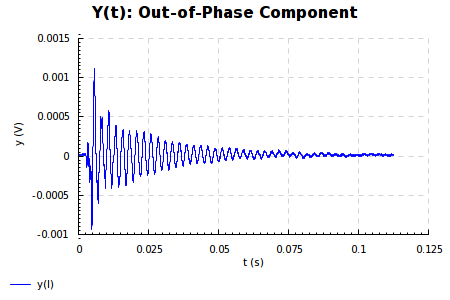

In [36]:
hystersisChart = toRenderable layout
  where
    lin = plot_lines_values .~ [toList $ removeUnit <$> signal]
         $ plot_lines_title .~ "y(I)"
         $ def

    layout = layout_title .~ "Y(t): Out-of-Phase Component"
           $ layout_plots .~ [toPlot $ lin]
           $ layout_x_axis . laxis_title .~ "t (s)"
           $ layout_y_axis . laxis_title .~ "y (V)" 
           $ def

hystersisChart 